In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machihack-houseprice/Test.csv
/kaggle/input/machihack-houseprice/sample_submission.csv
/kaggle/input/machihack-houseprice/Train.csv


In [2]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

machihack-houseprice



In [3]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('/kaggle/input/machihack-houseprice/Train.csv')
test = pd.read_csv('/kaggle/input/machihack-houseprice/Test.csv')

In [4]:
train = train.rename(columns = {"TARGET(PRICE_IN_LACS)":"TARGET"}) 

##display the first five rows of the train dataset.
train.head(5)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET
0,Owner,0,0,2,BHK,1300.236,1,1,"Ksfc Layout,Bangalore",12.970,77.598,55.000
1,Dealer,0,0,2,BHK,1275.000,1,1,"Vishweshwara Nagar,Mysore",12.275,76.645,51.000
2,Owner,0,0,2,BHK,933.160,1,1,"Jigani,Bangalore",12.778,77.632,43.000
3,Owner,0,1,2,BHK,929.921,1,1,"Sector-1 Vaishali,Ghaziabad",28.642,77.344,62.500
4,Dealer,1,0,2,BHK,999.009,0,1,"New Town,Kolkata",22.592,88.485,60.500


In [5]:
##display the first five rows of the test dataset.
test.head(5)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE
0,Owner,0,0,1,BHK,545.171,1,1,"Kamrej,Surat",21.262,73.048
1,Dealer,1,1,2,BHK,800.000,0,0,"Panvel,Lalitpur",18.966,73.148
2,Dealer,0,0,2,BHK,1257.097,1,1,"New Town,Kolkata",22.592,88.485
3,Dealer,0,0,3,BHK,1400.329,1,1,"Kalwar Road,Jaipur",26.988,75.585
4,Owner,0,0,1,BHK,430.478,1,1,"Mai Mandir,Nadiad",22.700,72.870


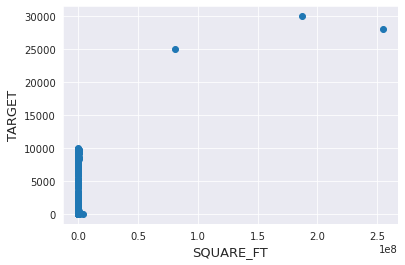

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['SQUARE_FT'], y = train['TARGET'])
plt.ylabel('TARGET', fontsize=13)
plt.xlabel('SQUARE_FT', fontsize=13)
plt.show()


 mu = 142.90 and sigma = 656.87



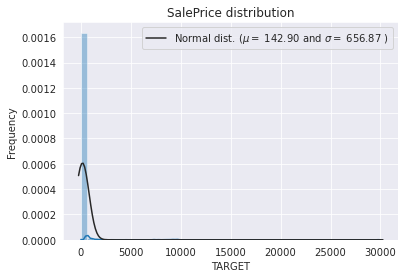

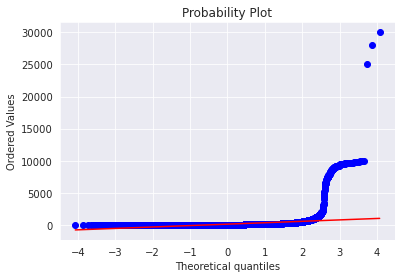

In [7]:
sns.distplot(train['TARGET'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['TARGET'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['TARGET'], plot=plt)
plt.show()

**Log-transformation of the target variable**


 mu = 4.23 and sigma = 0.88



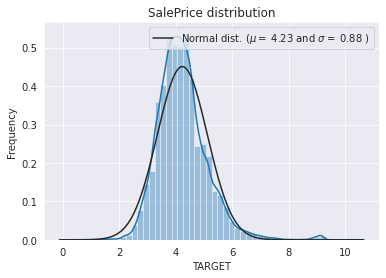

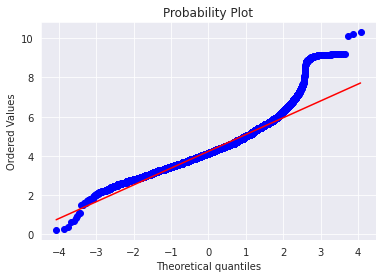

In [8]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["TARGET"] = np.log1p(train["TARGET"])

#Check the new distribution 
sns.distplot(train['TARGET'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['TARGET'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['TARGET'], plot=plt)
plt.show()

**Features engineering**

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.TARGET.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['TARGET','ADDRESS','LONGITUDE','LATITUDE'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (98171, 8)


In [10]:
print (all_data.dtypes)

POSTED_BY              object
UNDER_CONSTRUCTION      int64
RERA                    int64
BHK_NO.                 int64
BHK_OR_RK              object
SQUARE_FT             float64
READY_TO_MOVE           int64
RESALE                  int64
dtype: object


In [11]:
from sklearn.preprocessing import LabelEncoder
cols = ('POSTED_BY', 'BHK_OR_RK')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (98171, 8)


In [12]:
all_data['UNDER_CONSTRUCTION'] = all_data['UNDER_CONSTRUCTION'].astype(str)
all_data['RERA'] = all_data['RERA'].astype(str)
all_data['READY_TO_MOVE'] = all_data['READY_TO_MOVE'].astype(str)
all_data['RESALE'] = all_data['RESALE'].astype(str)
all_data['POSTED_BY'] = all_data['POSTED_BY'].astype(str)
all_data['BHK_OR_RK'] = all_data['BHK_OR_RK'].astype(str)

In [13]:
print (all_data.dtypes)

POSTED_BY              object
UNDER_CONSTRUCTION     object
RERA                   object
BHK_NO.                 int64
BHK_OR_RK              object
SQUARE_FT             float64
READY_TO_MOVE          object
RESALE                 object
dtype: object


In [14]:
all_data.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE
0,2,0,0,2,0,1300.236,1,1
1,1,0,0,2,0,1275.000,1,1
2,2,0,0,2,0,933.160,1,1
3,2,0,1,2,0,929.921,1,1
4,1,1,0,2,0,999.009,0,1


In [15]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
SQUARE_FT,208.064
BHK_NO.,2.326


In [16]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 2 skewed numerical features to Box Cox transform


In [17]:
all_data.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE
0,2,0,0,1.194,0,12.880,1,1
1,1,0,0,1.194,0,12.822,1,1
2,2,0,0,1.194,0,11.932,1,1
3,2,0,1,1.194,0,11.922,1,1
4,1,1,0,1.194,0,12.123,0,1


In [18]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(98171, 15)


In [19]:
all_data.head()

,BHK_NO.,SQUARE_FT,POSTED_BY_0,POSTED_BY_1,POSTED_BY_2,UNDER_CONSTRUCTION_0,UNDER_CONSTRUCTION_1,RERA_0,RERA_1,BHK_OR_RK_0,BHK_OR_RK_1,READY_TO_MOVE_0,READY_TO_MOVE_1,RESALE_0,RESALE_1
0,1.194,12.880,0,0,1,1,0,1,0,1,0,0,1,0,1
1,1.194,12.822,0,1,0,1,0,1,0,1,0,0,1,0,1
2,1.194,11.932,0,0,1,1,0,1,0,1,0,0,1,0,1
3,1.194,11.922,0,0,1,1,0,0,1,1,0,0,1,0,1
4,1.194,12.123,0,1,0,0,1,1,0,1,0,1,0,0,1


In [20]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [21]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [22]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [23]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [24]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [25]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [26]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [27]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [28]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [29]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.6365 (0.0130)



In [30]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.6365 (0.0130)



In [31]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.6138 (0.0044)



In [32]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.5758 (0.0037)



In [33]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[01:46:39] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:47:03] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:47:26] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:47:50] WARNING: ..

In [34]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.5977 (0.0039)



In [35]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [36]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.5996 (0.0042)



In [37]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [38]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.5733 (0.0035)


In [39]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [40]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.5552959477752731


In [41]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[03:12:49] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.5556724675457367


In [42]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.5954544889787406


In [43]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.5578361248283505


In [44]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [45]:
from IPython.display import HTML

sub = pd.DataFrame()
sub['cc_cons'] = ensemble
sub.to_csv('submission.csv',index=False)


def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

# create a link to download the dataframe which was saved with .to_csv method
create_download_link(filename='submission.csv')